In [35]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

# TRANSVERSE
def plot_lscale(directory,flist,ist=0,ien=-1,savename=None):
    
    fig,ax = plt.subplots(1,4,figsize=(10,3), dpi=200)
    lscales = np.zeros([3,len(flist)])
    
    for count,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = tID.split('.dat')[0]
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        
        if inp.rr==1: pass
        else: 
            ic,yc = get_centerline(directory,y,int(tID))
            eta -= yc/dtheta 
        
        # Get transverse decorr lengthscale
        autocorr = np.fromfile(fname, sep=' ',count=-1)
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = -1*autocorr[:,0] #[yc,yc+offset,yc-offset]
        ly,i1,i2 = get_lscale(y,autocorr,thresh=0.2)
        ax[0].plot(eta, autocorr,alpha=1,label='tID=%s,t=%d'%(tID,time))
        
        # Get 99% lengthscale
        utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',sep=' ')
        L99,tmp1,tmp2 = get_L99(y,utilde)

        ax[0].plot([eta[i1],eta[i2]],[0.2,0.2],'k-*')
        ax[1].plot(eta, utilde/inp.du, alpha=1)
        ax[2].plot(time,L99,'k*',)
        ax[2].plot(time,dtheta,'k^',)
        ax[2].plot(time,ly,'*',)        
        ax[3].plot(time,ly/L99,'k*',)        
        ax[3].plot(time,ly/dtheta,'k^',)        

        xmax = L99/dtheta/2.
        ax[0].set_title('Autocorrelation')
        ax[0].set_xlim([-xmax,xmax])
        ax[0].set_xlabel(r'$\eta$')
        ax[1].set_title(r'$\tilde{u}/\Delta \bar{u}$')
        ax[1].set_xlim([-xmax,xmax])
        ax[1].set_xlabel(r'$\eta$')
        ax[2].set_xlabel('t')
        ax[2].legend([r'$L_{99}$',r'$\delta_\theta$','$L_y$'])
        ax[3].legend([r'$L_y/L_{99}$',r'$L_y/\delta_\theta$'])
        ax[3].set_xlabel('t')
        
        lscales[0,count] = ly
        lscales[1,count] = ly/L99
        lscales[2,count] = ly/dtheta
        namelist = ['L','L/L99','L/dtheta']
        
    for a in ax: a.grid(True)

    if savename is None:
        for i,name in enumerate(namelist):
            print(name)
            print('{}: [{}, {}],'.format(inp.Mc,np.mean(lscales[i,ist:ien]),np.std(lscales[i,ist:ien])))
    else:
        fig.savefig(savename,dpi=200, bbox_inches='tight')
        plt.close()
        print('Saved to {}'.format(savename))

def get_lscale_vs_t(directory,flist):
    mat = np.zeros([len(flist),2])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta

        # Get y lengthscale
        autocorr = np.fromfile(fname,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        ly,i1,i2 = get_lscale(y,-(autocorr[:,0]),thresh=0.2)

        # Get 99% lengthscale
        utilde = np.fromfile( directory+'shearlayer_utilde_%04d.dat'%tID, sep=' ')
        L99,i1,i2 = get_L99(y,utilde)
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = ly/L99
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

In [89]:
directory = '/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc04/rr1/1024x1448x512/'
# directory = '/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
z = np.linspace(0,Lz,Nz)
x = np.linspace(0,Lx,Nx)
y = np.linspace(Ly/2.,-Ly/2.,Ny)

flist = glob.glob(directory+"*crosscorr_upvpp_*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 0.4
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['crosscorr_upvpp_0000.dat', 'crosscorr_upvpp_0001.dat', 'crosscorr_upvpp_0002.dat', 'crosscorr_upvpp_0003.dat', 'crosscorr_upvpp_0004.dat', 'crosscorr_upvpp_0005.dat', 'crosscorr_upvpp_0006.dat', 'crosscorr_upvpp_0007.dat', 'crosscorr_upvpp_0008.dat', 'crosscorr_upvpp_0009.dat', 'crosscorr_upvpp_0010.dat']


0.4: [0.405678507404,0.0357740875077],


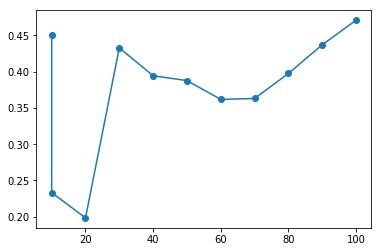

In [92]:
mat=get_lscale_vs_t(directory,flist)
plt.plot(mat[:,0],mat[:,1],'-o')

ist = 3
ien = None
print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[ist:ien,1]),np.std(mat[ist:ien,1])))

L
2.0: [7.08131766874, 2.44280274417],
L/L99
2.0: [0.327046223615, 0.03344793256],
L/dtheta
2.0: [3.20562352764, 0.301775790011],


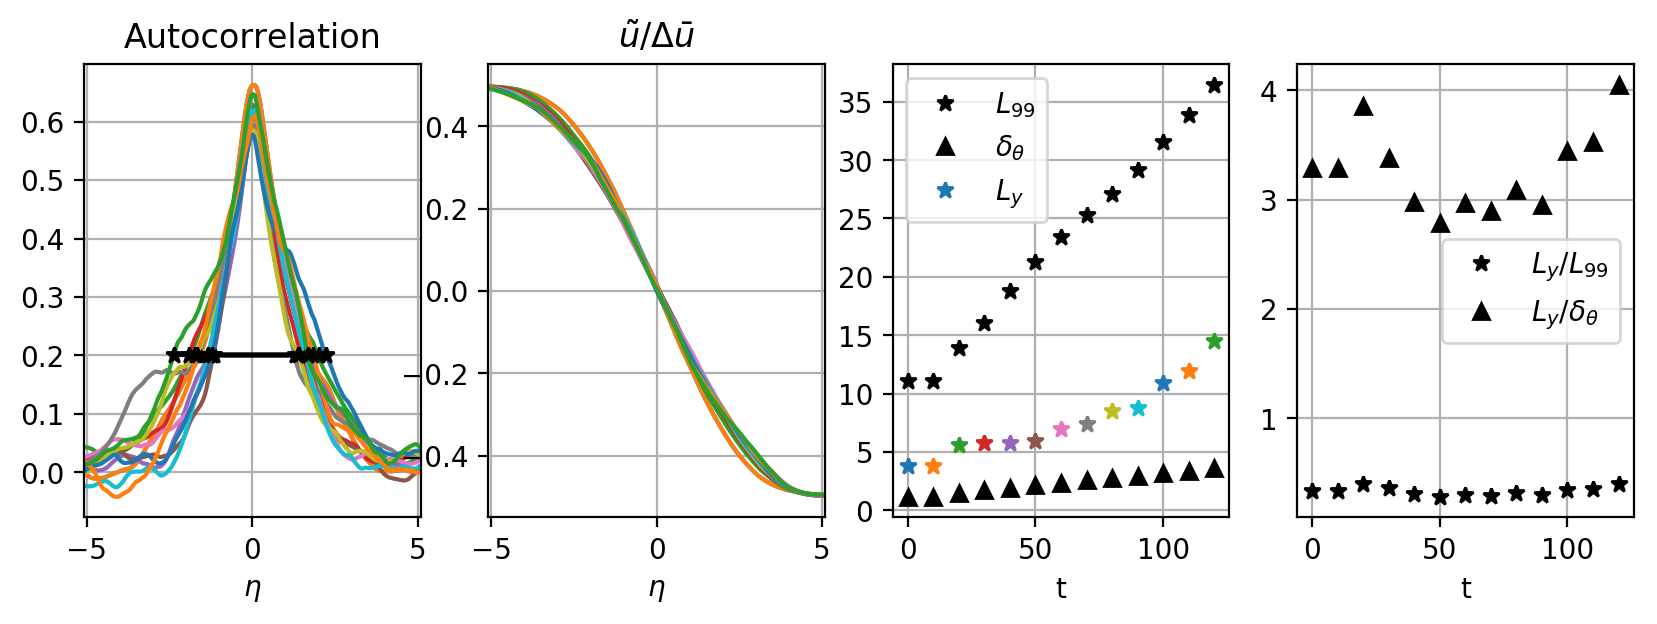

In [20]:
plot_lscale(directory,flist[0:-1],ist=0,ien=-1)

In [520]:
s = '1'

if s=='1': Mc_list =['20',]# ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    

fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    z = np.linspace(0,Lz,Nz)
    x = np.linspace(0,Lx,Nx)
    y = np.linspace(Ly/2.,-Ly/2.,Ny)

    dir_out = directory.split('/projects/ShockInducedMix/')[-1]
    dir_out = '/home/kmatsuno/' + dir_out + '/'
    
    if Mc=='02': ist=9;ien=-1
    elif Mc=='04': ist=2;ien=13-4
    else: ist=0; ien=-1
        
    q = 'v'
    flist = glob.glob(dir_out+"*lscale_{}{}*".format(q,q))
    flist.sort()
    for corr_dir in ['x','y','z']:
        savename='/home/kmatsuno/ShearLayer_img/lscale_{}/profile_Mc{}_s{}_{}.png'.format(q,Mc,s,corr_dir)
        if corr_dir=='y':plot_lscale(directory,flist[ist:ien],savename=savename)
        else: plot_lscale_xz(directory,flist[ist:ien],corr_dir=corr_dir,savename=savename)

Saved to /home/kmatsuno/ShearLayer_img/lscale_v/profile_Mc20_s1_x.png
Saved to /home/kmatsuno/ShearLayer_img/lscale_v/profile_Mc20_s1_y.png
Saved to /home/kmatsuno/ShearLayer_img/lscale_v/profile_Mc20_s1_z.png


<Figure size 750x450 with 0 Axes>